reduzir imagem (500x 500) primeiro
depois aumente para o tamanho original

baseline da disparidade

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

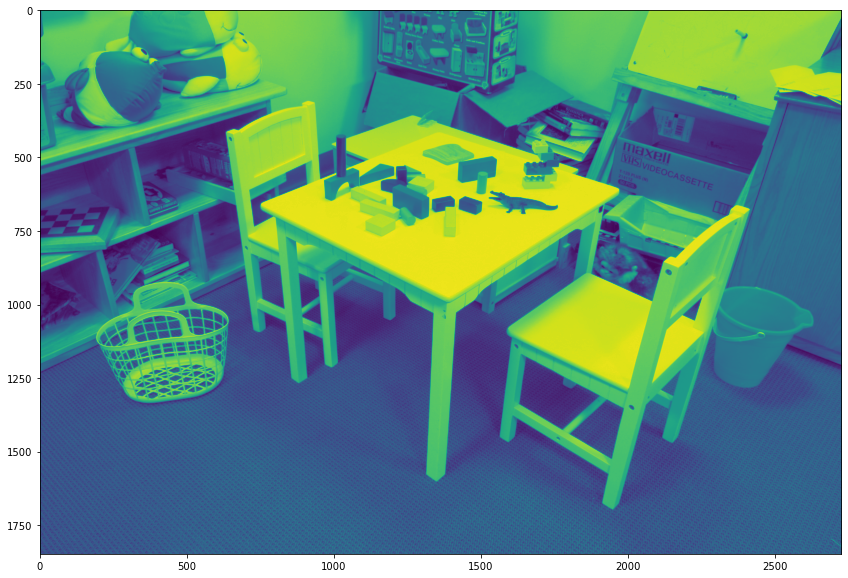

In [7]:

fig, ax = plt.subplots(figsize=(20, 10))

# imgL = cv.imread('stereo_data/data/Middlebury/Jadeplant-perfect/im0.png',0)
# imgR = cv.imread('stereo_data/data/Middlebury/Jadeplant-perfect/im1.png',0)

imgL = cv.imread('data/Middlebury/Playtable-perfect/im0.png',0)
imgR = cv.imread('data/Middlebury/Playtable-perfect/im1.png',0)

#
# imgL_denoised = cv.GaussianBlur(imgL,(5,5),0)
# imgR_denoised = cv.GaussianBlur(imgR,(5,5),0)
#
plt.imshow(imgL)
plt.show()

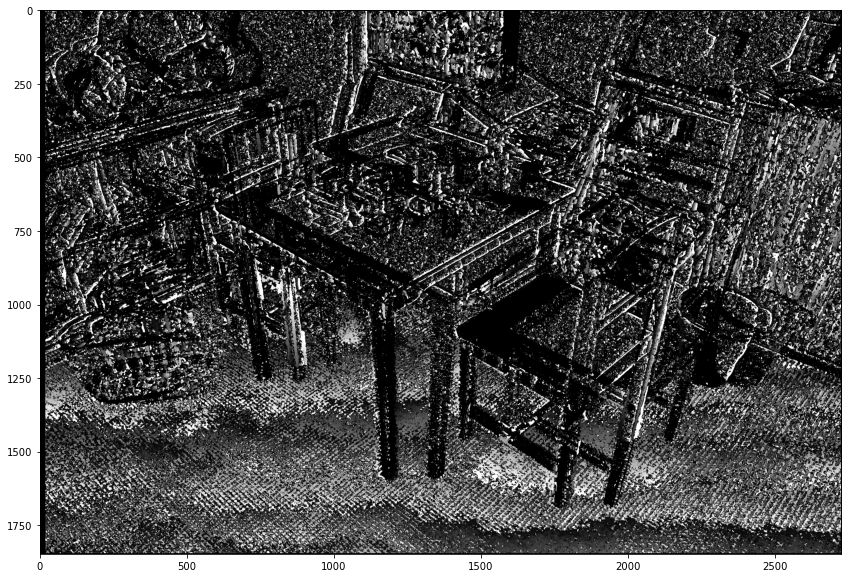

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
stereo = cv.StereoBM_create(numDisparities=16, blockSize=7)
disparity_left = stereo.compute(imgL,imgR)
plt.imshow(disparity_left,'gray')
plt.show()

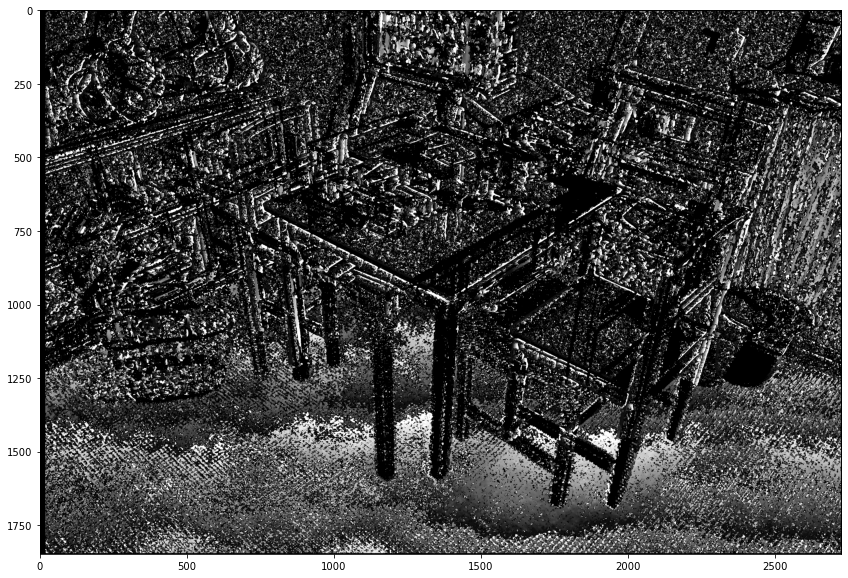

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
stereo = cv.StereoBM_create(numDisparities=16, blockSize=7)
disparity_right = stereo.compute(imgR, imgL)
plt.imshow(disparity_right,'gray')
plt.show()

### Tenta calcular a disparidade só com as bordas
pega bordas com laplaciana

### Left

In [41]:
# converting to gray scale
gray = cv.cvtColor(imgL, cv.CV_32S)

# remove noise
imgL_denoised = cv.GaussianBlur(gray,(5,5),0)

# convolute with proper kernels
laplacian_l = cv.Laplacian(imgL_denoised,cv.CV_64F)

In [42]:
laplacian_l = laplacian_l * 0.2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


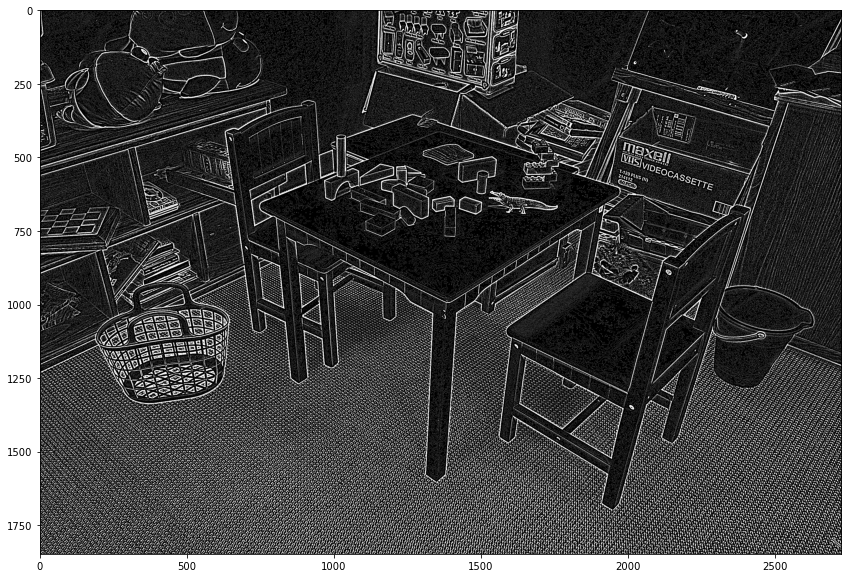

In [43]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(laplacian_l,'gray')
plt.show()

### Right

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


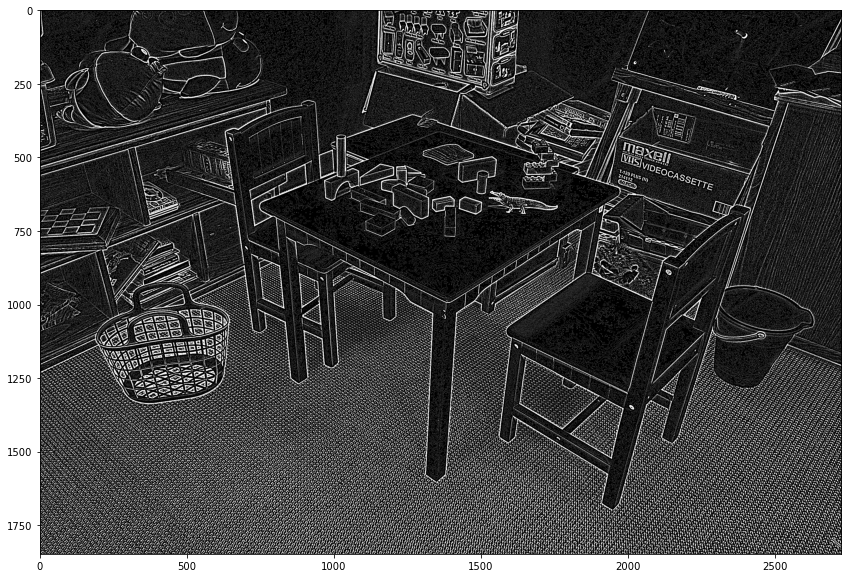

In [44]:
# converting to gray scale
gray = cv.cvtColor(imgR, cv.CV_32S)

# remove noise
imgR_denoised = cv.GaussianBlur(gray,(5,5),0)

# convolute with proper kernels
laplacian_r = cv.Laplacian(imgL_denoised,cv.CV_64F)

laplacian_r = laplacian_r * 0.2

fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(laplacian_r,'gray')
plt.show()

In [45]:
# cv.imwrite('laplacian_l.png',laplacian_l)
# cv.imwrite('laplacian_r.png',laplacian_r)

In [46]:
# laplacian_l = cv.imread('stereo_data/laplacian_l.png',0)
# laplacian_r = cv.imread('stereo_data/laplacian_r.png',0)

disparity = stereo.compute(laplacian_l,laplacian_r)
plt.imshow(disparity,'gray')
plt.show()

error: OpenCV(4.1.0) ../modules/calib3d/src/stereobm.cpp:1113: error: (-210:Unsupported format or combination of formats) Both input images must have CV_8UC1 in function 'compute'


## Não funciona..

In [18]:
# SGBM Parameters -----------------
window_size = 3                     # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
 
left_matcher = cv.StereoSGBM_create(
    minDisparity=0,
    numDisparities=160,             # max_disp has to be dividable by 16 f. E. HH 192, 256
    blockSize=5,
    P1=8 * 3 * window_size ** 2,    # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
    P2=32 * 3 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=0,
    speckleRange=2,
    preFilterCap=63,
    mode=cv.STEREO_SGBM_MODE_SGBM_3WAY
)

right_matcher = cv.ximgproc.createRightMatcher(left_matcher)


In [20]:
# FILTER Parameters
lmbda = 80000
sigma = 1.2
visual_multiplier = 1.0

wls_filter = cv.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)

In [21]:
print('computing disparity...')
displ = left_matcher.compute(imgL, imgR)  # .astype(np.float32)/16
dispr = right_matcher.compute(imgR, imgL)  # .astype(np.float32)/16
displ = np.int16(displ)
dispr = np.int16(dispr)
filteredImg = wls_filter.filter(displ, imgL, None, dispr)  

computing disparity...


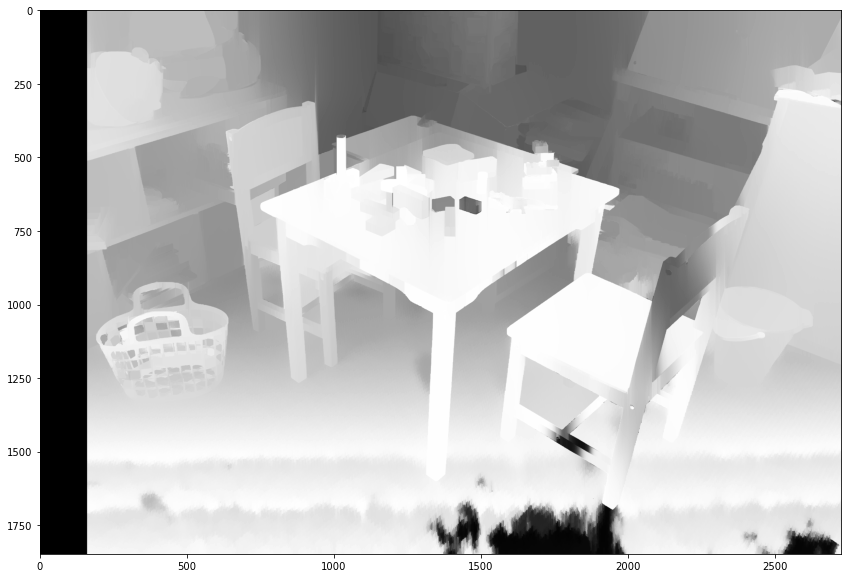

In [28]:
filteredImg = cv.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv.NORM_MINMAX);
filteredImg = np.uint8(filteredImg)

plt.rcParams["figure.figsize"] = (15, 10)
plt.imshow(filteredImg, 'gray')
plt.show()